In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/My Drive/ADNI_DATASET'
classes = ['AD', 'CN', 'EMCI', 'MCI']
IMG_SIZE = 256



In [ ]:
# Function to load raw images
def load_raw_images(data_dir, classes, img_size, sample_size=200):
    data = []
    labels = []
    for c in classes:
        path = os.path.join(data_dir, c)
        class_num = classes.index(c)
        images = os.listdir(path)[:sample_size]  # Load 200 images per class
        for img in images:
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                if img_array is None:
                    print(f"Failed to read image {img}")
                    continue
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image {img}: {e}")
                continue
    # Ensure consistent shapes
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [ ]:
# Function to preprocess images
def preprocess_images(data):
    data_normalized = data / 255.0  # Normalize
    data_preprocessed = np.zeros_like(data_normalized)
    for i in range(data_normalized.shape[0]):
        data_preprocessed[i] = cv2.equalizeHist((data_normalized[i] * 255).astype(np.uint8)) / 255.0
    return data_preprocessed

In [ ]:
# Load raw images
raw_data, raw_labels = load_raw_images(base_dir, classes, IMG_SIZE)

In [ ]:
# Function to plot class distribution
def plot_class_distribution(labels, classes, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.show()

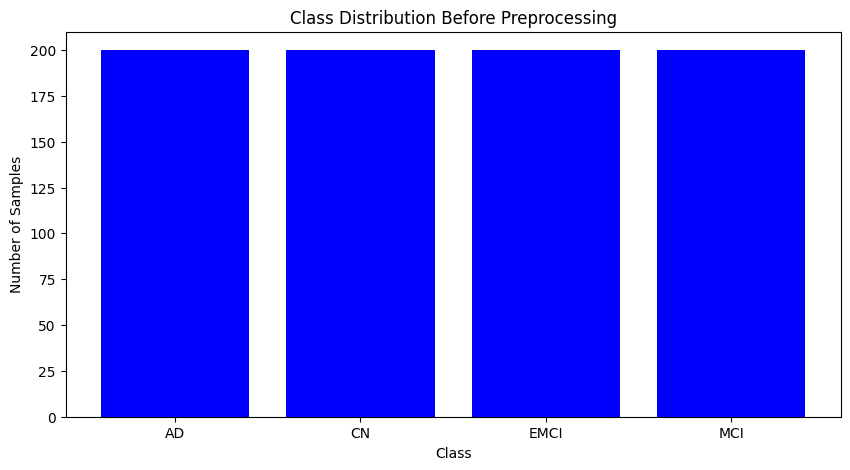

In [ ]:
# Plot class distribution before preprocessing
plot_class_distribution(raw_labels, classes, title="Class Distribution Before Preprocessing")

In [ ]:
# Preprocess images
preprocessed_data = preprocess_images(raw_data)

In [ ]:
# Function to display images
def display_images(images, labels, classes, title, num_images=4):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [ ]:
# Select one image per class
selected_images = []
selected_labels = []
for c in range(len(classes)):
    idx = np.where(raw_labels == c)[0][0]  # Select the first image of each class
    selected_images.append(raw_data[idx])
    selected_labels.append(raw_labels[idx])

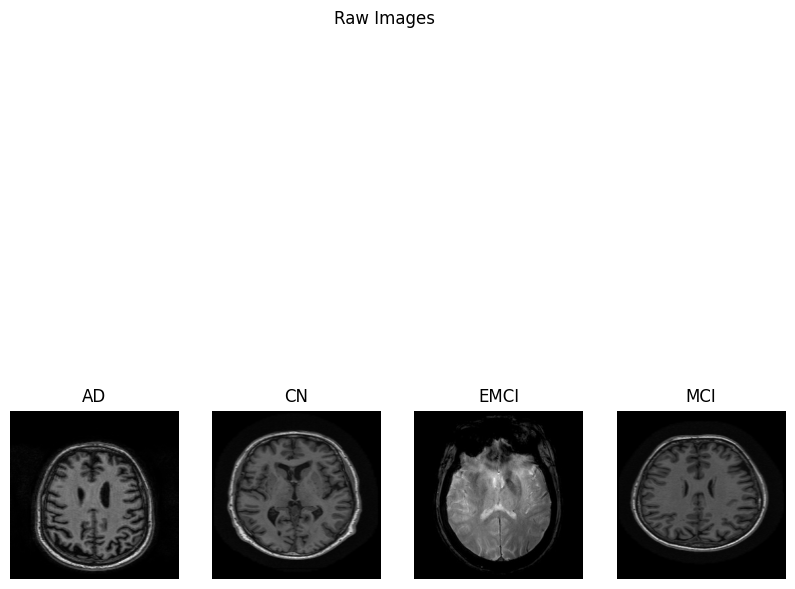

In [ ]:
# Display raw images
display_images(np.array(selected_images), np.array(selected_labels), classes, title="Raw Images")

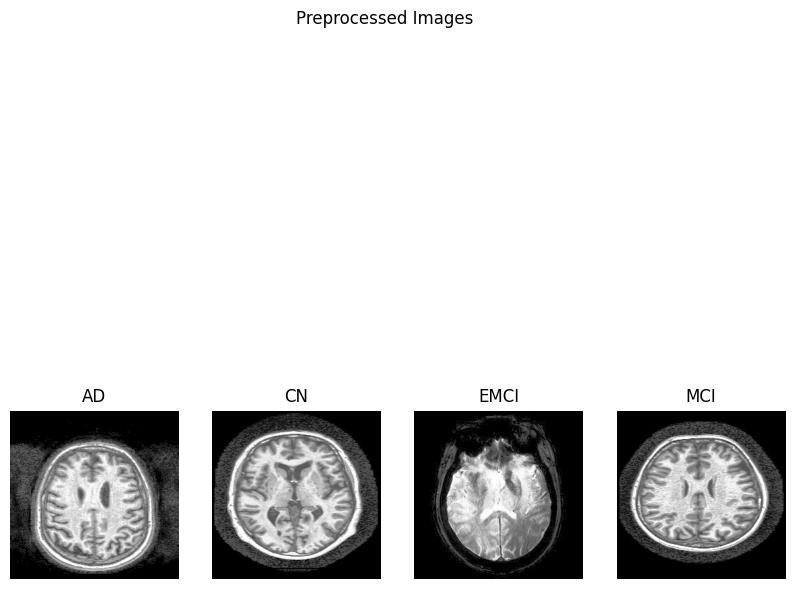

In [ ]:
# Display preprocessed images
preprocessed_selected_images = preprocess_images(np.array(selected_images))
display_images(preprocessed_selected_images, np.array(selected_labels), classes, title="Preprocessed Images")

In [ ]:
# Flatten the images for SVM input
X_flatten = preprocessed_data.reshape(preprocessed_data.shape[0], -1)

# Encode labels for SVM
le = LabelEncoder()
y_svm = le.fit_transform(raw_labels)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flatten, y_svm, test_size=0.3, random_state=42)

In [ ]:
# Print shapes to verify
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (560, 65536)
y_train shape: (560,)
X_test shape: (240, 65536)
y_test shape: (240,)


In [ ]:
# Define the SVM model with higher regularization
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=0.1, probability=True))
])

In [ ]:
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

Cross-validation scores: [0.99107143 1.         0.99107143 1.         0.99107143]
Mean cross-validation score: 0.9946428571428572


In [ ]:
# Train the SVM model
svm_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=0.1, kernel='linear', probability=True))])

In [ ]:
# Make predictions on the training set
y_train_pred = svm_model.predict(X_train)

# Evaluate the model on the training set
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred, target_names=classes))

Training Accuracy: 1.0
Training Classification Report:
               precision    recall  f1-score   support

          AD       1.00      1.00      1.00       138
          CN       1.00      1.00      1.00       137
        EMCI       1.00      1.00      1.00       149
         MCI       1.00      1.00      1.00       136

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [ ]:
y_test_pred = svm_model.predict(X_test)

# Evaluate the model on the test set
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred, target_names=classes))

Testing Accuracy: 1.0
Testing Classification Report:
               precision    recall  f1-score   support

          AD       1.00      1.00      1.00        62
          CN       1.00      1.00      1.00        63
        EMCI       1.00      1.00      1.00        51
         MCI       1.00      1.00      1.00        64

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [ ]:
# Define parameter grid for SVM
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1)


In [ ]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(C=0.1, kernel='linear',
                                            probability=True))]),
             param_grid={'svm__C': [0.01, 0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'svm__C': 0.01, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best Score: 0.9946428571428572


In [ ]:
best_svm_model = grid_search.best_estimator_
y_test_pred_best = best_svm_model.predict(X_test)


In [ ]:

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_test_pred_best))
print("Classification Report:\n", classification_report(y_test, y_test_pred_best, target_names=classes))

Best Model Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

          AD       1.00      1.00      1.00        62
          CN       1.00      1.00      1.00        63
        EMCI       1.00      1.00      1.00        51
         MCI       1.00      1.00      1.00        64

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

